<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Fine Tuning Overview</center></font></h1>
<h1><center>Dialogue Summarization Use Case</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

# **Fine-Tune a Generative AI Model for Dialogue Summarization**

In this notebook, you will fine-tune an existing LLM from Hugging Face for enhanced dialogue summarization. You will use the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model, which provides a high quality instruction tuned model and can summarize text out of the box. To improve the inferences, you will explore a full fine-tuning approach and evaluate the results with ROUGE metrics. Then you will perform Parameter Efficient Fine-Tuning (PEFT), evaluate the resulting model and see that the benefits of PEFT outweigh the slightly-lower performance metrics.

# **Table of Contents**

- [ 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM](#1)
  - [ 1.1 - Set up Kernel and Required Dependencies](#1.1)
  - [ 1.2 - Load Dataset and LLM](#1.2)
  - [ 1.3 - Test the Model with Zero Shot Inferencing](#1.3)
- [ 2 - Perform Full Fine-Tuning](#2)
  - [ 2.1 - Preprocess the Dialog-Summary Dataset](#2.1)
  - [ 2.2 - Fine-Tune the Model with the Preprocessed Dataset](#2.2)
  - [ 2.3 - Evaluate the Model Qualitatively (Human Evaluation)](#2.3)
  - [ 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)](#2.4)
- [ 3 - Perform Parameter Efficient Fine-Tuning (PEFT)](#3)
  - [ 3.1 - Setup the PEFT/LoRA model for Fine-Tuning](#3.1)
  - [ 3.2 - Train PEFT Adapter](#3.2)
  - [ 3.3 - Evaluate the Model Qualitatively (Human Evaluation)](#3.3)
  - [ 3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)](#3.4)

## **1 - Set up Kernel, Load Required Dependencies, Dataset and LLM**

### 1.1 - Set up Kernel and Required Dependencies

Now install the required packages for the LLM and datasets.



In [ ]:
# Upgrade pip to the latest version
%pip install --upgrade pip

# Disable pip version checks (suppress version check warnings)
%pip install --disable-pip-version-check

# Install specific versions of PyTorch and related libraries
%pip install torch==1.13.1 torchdata==0.5.1 --quiet

# Install specific versions of NLP-related libraries
%pip install transformers==4.27.2 datasets==2.11.0 evaluate==0.4.0 rouge_score==0.1.2 loralib==0.1.1 peft==0.3.0 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: You must give at least one requirement to install (see "pip help install")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 99.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires

Import the necessary components. Some of them are new for this week, they will be discussed later in the notebook.

In [ ]:
# Import the 'load_dataset' function from the 'datasets' module to load data
from datasets import load_dataset

# Import specific components from the 'transformers' library for working with language models
from transformers import (
    AutoModelForSeq2SeqLM,  # Import the Seq2Seq language model class
    AutoTokenizer,           # Import the tokenizer for language models
    GenerationConfig,       # Import the generation configuration for text generation
    TrainingArguments,      # Import training arguments for fine-tuning models
    Trainer                 # Import the Trainer class for model training
)

# Import the 'torch' library to work with PyTorch, a popular deep learning framework
import torch

# Import the 'time' module to measure and manage time-related operations
import time

# Import a custom module named 'evaluate' for evaluation purposes
import evaluate

# Import the 'pandas' library for working with data in a tabular format (DataFrames)
import pandas as pd

# Import the 'numpy' library for numerical and array operations
import numpy as np


### **1.2-Load Dataset and LLM**

You with experiment with the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [ ]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-cd36827d3490488d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
})

The given data structure is a DatasetDict object, which is typically used in libraries like Hugging Face's datasets for organizing and managing datasets.

**train:**

- A Dataset object representing the training dataset.
It contains features with the keys 'id,' 'dialogue,' 'summary,' and 'topic.'
- The training dataset consists of 12,460 rows or examples.

**test:**

- A Dataset object representing the testing dataset.
It also contains features with the keys 'id,' 'dialogue,' 'summary,' and 'topic.'
- The testing dataset consists of 1,500 rows or examples.

**validation:**

- A Dataset object representing the validation dataset.
It includes the same features with 'id,' 'dialogue,' 'summary,' and 'topic.'
- The validation dataset consists of 500 rows or examples.


Load the pre-trained [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Notice that you will be using the [small version](https://huggingface.co/google/flan-t5-base) of FLAN-T5. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.

In [ ]:
# Define the model name, specifying the pre-trained model to be used
model_name = 'google/flan-t5-base'

# Load the pre-trained model for sequence-to-sequence tasks
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)

# Load the tokenizer associated with the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)


(…)le/flan-t5-base/resolve/main/config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

(…)base/resolve/main/generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

(…)-base/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

(…)flan-t5-base/resolve/main/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

(…)ase/resolve/main/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

**Trainnable parameters** : It is possible to pull out the number of model parameters and find out how many of them are trainable. The following function can be used to do that, at this stage, you do not need to go into details of it.

The following code defines a function called print_number_of_trainable_model_parameters that calculates and prints information about the number of trainable and total model parameters in a given neural network model.

In [ ]:
def print_number_of_trainable_model_parameters(model):
    # Initialize variables to count trainable and all model parameters
    trainable_model_params = 0
    all_model_params = 0

    # Loop through named parameters of the model
    for _, param in model.named_parameters():
        # Count the total number of model parameters
        all_model_params += param.numel()

        # Check if the parameter requires gradient (is trainable)
        if param.requires_grad:
            # If trainable, count it as a trainable parameter
            trainable_model_params += param.numel()

    # Calculate the percentage of trainable parameters
    percentage_trainable = 100 * trainable_model_params / all_model_params

    # Return a formatted string with parameter information
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {percentage_trainable:.2f}%"

# Call the function with the 'original_model' as an argument and print the results
print(print_number_of_trainable_model_parameters(original_model))


trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


- trainable model parameters: 247577856": This means that there are 247,577,856 parameters in the model that are marked as trainable. These are the parameters that the model will update during training to learn from the data.

- "all model parameters: 247577856": This represents the total number of parameters in the model, which is also 247,577,856. This includes both trainable parameters and non-trainable parameters. Non-trainable parameters are typically fixed, such as embeddings or other pre-trained components of the model that are not updated during training.

- "percentage of trainable model parameters: 100.00%": This percentage indicates that all of the model's parameters are trainable. In other words, the model does not contain any fixed (non-trainable) parameters. This is often the case with models that are initialized from scratch or models where all parameters are intended to be fine-tuned during training.

### **1.3 - Test the Model with Zero Shot Inferencing**

Test the model with the zero shot inferencing. You can see that the model struggles to summarize the dialogue compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [ ]:
# Select the index of the example you want to process from the dataset
index = 200

# Retrieve the 'dialogue' and 'summary' from the 'test' split of the dataset
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

# Create a prompt that includes the dialogue for summarization
prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

# Tokenize the prompt using the model's tokenizer and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')

# Generate a summary using the original model, limiting the summary to a maximum of 200 tokens
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))

# Print the input prompt, human-written summary, and model-generated summary
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

## **2 - Perform Full Fine-Tuning**


### **2.1 - Preprocess the Dialog-Summary Dataset**

You need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [ ]:
# Define a function to tokenize and preprocess dataset examples
def tokenize_function(example):
    # Define start and end prompts for summarization
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '

    # Create a list of prompts, one for each dialogue in the example
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]

    # Tokenize the prompts using the model's tokenizer
    # Set padding, truncation, and return type to PyTorch tensors
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids

    # Tokenize the summary using the tokenizer
    # Set padding, truncation, and return type to PyTorch tensors
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# Apply the tokenize_function to the entire dataset using batch processing
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns from the processed dataset
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary'])


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

**To save some time, you will subsample the dataset:**

In [ ]:
# Filter the tokenized dataset using a lambda function
tokenized_datasets = tokenized_datasets.filter(
    lambda example, index: index % 100 == 0, with_indices=True
)
# this line of code filters the tokenized_datasets to retain only every 100th example in the dataset, allowing you to create a smaller
# subset of the dataset for specific purposes, such as evaluation or testing,
# while excluding the majority of examples.

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

**Check the shapes of all three parts of the dataset:**

In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (125, 2)
Validation: (5, 2)
Test: (15, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 125
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 5
    })
})


**The output dataset is ready for fine-tuning.**

### **2.2 - Fine-Tune the Model with the Preprocessed Dataset**

Now utilize the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [ ]:
# Define an output directory for training results
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

# Define training arguments using the TrainingArguments class
training_args = TrainingArguments(
    output_dir=output_dir,       # Directory to save training results
    learning_rate=1e-5,         # Learning rate for optimization
    num_train_epochs=1,         # Number of training epochs (1 in this case)
    weight_decay=0.01,          # Weight decay for regularization
    logging_steps=1,            # Logging frequency during training
    max_steps=1                # Maximum number of training steps (1 in this case)
)

# Create a Trainer instance for model training
trainer = Trainer(
    model=original_model,            # The model to be trained
    args=training_args,              # Training arguments
    train_dataset=tokenized_datasets['train'],   # Training dataset
    eval_dataset=tokenized_datasets['validation'] # Validation dataset
)


Start training process...



In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,49.500000


TrainOutput(global_step=1, training_loss=49.5, metrics={'train_runtime': 5.494, 'train_samples_per_second': 1.456, 'train_steps_per_second': 0.182, 'total_flos': 5478058819584.0, 'train_loss': 49.5, 'epoch': 0.06})

**The trainer.train()** method is responsible for initiating the training process for a machine learning model. When this method is called, the training process begins. Here's what happens when trainer.train() is executed:

- Initialization: Before training starts, the trainer initializes various components, such as data loaders, optimizers, and logging.

- Epochs: The trainer loops through the specified number of training epochs. In your code, you've set num_train_epochs to 1, which means there will be a single training epoch.

- Batches: Within each epoch, the trainer further divides the training dataset into batches. These batches are used for mini-batch gradient descent, which helps optimize the model in smaller steps.

- Forward and Backward Pass: For each batch, the trainer performs a forward pass, where it computes predictions from the model based on the input data. Then, it computes the loss by comparing the predictions to the target labels (ground truth). Following this, a backward pass (backpropagation) is executed to calculate gradients.

- Gradient Descent: The trainer updates the model's parameters using the gradients and the selected optimization algorithm (usually some variant of stochastic gradient descent, like Adam).

- Logging and Metrics: During training, the trainer logs various metrics (loss, accuracy, etc.) and other information at specified intervals (controlled by logging_steps).

- Validation: After each epoch or at specific intervals, the trainer evaluates the model on the validation dataset (eval_dataset). This evaluation helps monitor how well the model is performing on data it hasn't seen during training. The evaluation results may include metrics such as validation loss or other relevant metrics.

- Early Stopping (Optional): In some training configurations, early stopping might be employed to halt training if the model's performance on the validation dataset starts deteriorating.

- Checkpointing: Periodically, the trainer saves model checkpoints, which are snapshots of the model's state. These checkpoints can be used for model restoration or later inference.

- Completion and Results: Once the specified number of epochs is completed (in your case, 1), the training process ends. The trainer returns information about the training process, such as final loss values, metrics, and other relevant data

Training a fully fine-tuned version of the model would take a few hours on a GPU (if there are no out of memory errors).

<a name='3'></a>
## 3 - **Perform Parameter Efficient Fine-Tuning (PEFT)**

Now, let's perform **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as you did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon.

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).  

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

**LoRA (Low-Rank Adaptation)**is a technique used in machine learning for adapting and fine-tuning pre-trained neural language models. LoRA is often used in the context of language modeling and sequence-to-sequence tasks. Here is an overview of the general process followed in LoRA:

- **Pre-Trained Model Selection**:

Begin by selecting a pre-trained neural language model (e.g., BERT, GPT-3, T5) that is well-suited for the target task. The model should be pre-trained on a large corpus of text and should have the desired architecture for the task at hand.
- **LoRA Configuration**:

Define the LoRA configuration, which includes hyperparameters and settings for adapting the model. This configuration specifies how the pre-trained model should be adapted to the target task. Parameters may include:
Rank (dimensionality reduction factor)
LoRA alpha (a scaling factor for the rank)
Dropout rate
Target modules (parts of the model to adapt, e.g., query or value modules)
Bias handling
Task type (e.g., sequence-to-sequence language modeling)
- **Adaptation**:

The LoRA model adapts the pre-trained model to the specific task. During adaptation, it fine-tunes the model's parameters to improve task-specific performance.
The low-rank adaptation process helps reduce the model's dimensionality, making it more suitable for the new task.
Fine-Tuning:

Fine-tuning is performed on the adapted model. During fine-tuning, the model is further trained on a task-specific dataset to optimize its performance. This step helps the model learn task-specific patterns.
- **Evaluation**:

The adapted and fine-tuned model is evaluated on a validation dataset to assess its performance and make any necessary adjustments to the configuration and hyperparameters.
- **Inference**:

Once the model is adapted, fine-tuned, and evaluated, it can be used for inference on new data. It takes input data and generates predictions or responses, depending on the task it was adapted for.

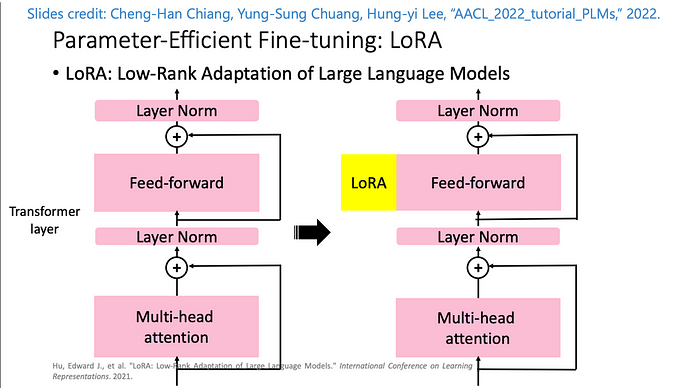

### **3.1 - Setup the PEFT/LoRA model for Fine-Tuning**

You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [ ]:
# Import necessary components from the 'peft' module
from peft import LoraConfig, get_peft_model, TaskType

# Create a LoraConfig object to configure the PEFT model
lora_config = LoraConfig(
    r=32,  # Rank - A parameter determining the number of attention heads in the model
    lora_alpha=32,  # LORA alpha - A hyperparameter for the PEFT model
    target_modules=["q", "v"],  # Define target modules for the LORA attention mechanism
    lora_dropout=0.05,  # Dropout rate to regularize the model
    bias="none",  # Specify the bias setting for LORA, in this case, 'none'
    task_type=TaskType.SEQ_2_SEQ_LM  # Define the task type for the PEFT model (Sequence-to-Sequence Language Model)
)


Add LoRA adapter layers/parameters to the original LLM to be trained.

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


### **3.2 - Train PEFT Adapter**

Define training arguments and create `Trainer` instance.

In [ ]:
# Define the output directory for saving the trained PEFT model
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

# Define training arguments for PEFT training
peft_training_args = TrainingArguments(
    output_dir=output_dir,      # Output directory for saving model checkpoints and logs
    auto_find_batch_size=True,  # Automatically find a suitable batch size
    learning_rate=1e-3,        # Learning rate for training (higher than full fine-tuning)
    num_train_epochs=1,         # Number of training epochs
    logging_steps=1,            # Number of steps between logging
    max_steps=50                # Maximum number of training steps
)

# Create a Trainer object for PEFT model training
peft_trainer = Trainer(
    model=peft_model,                       # The PEFT model to train
    args=peft_training_args,                # Training arguments
    train_dataset=tokenized_datasets["train"]  # Training dataset for fine-tuning
)


Now everything is ready to train the PEFT adapter and save the model.



In [ ]:
# Train the PEFT model using the Trainer
peft_trainer.train()

# Define the path to save the trained PEFT model
peft_model_path = "./peft-dialogue-summary-checkpoint-local"

# Save the trained PEFT model to the specified path
peft_trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer associated with the PEFT model to the same path
tokenizer.save_pretrained(peft_model_path)


Step,Training Loss
1,51.500000
2,49.000000
3,44.000000
4,38.750000
5,35.500000
6,31.000000
7,29.750000
8,26.125000
9,25.500000
10,22.750000


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

Check that the size of this model is much less than the original LLM:

In [ ]:
!ls -al ./peft-dialogue-summary-checkpoint-local/adapter_model.bin

-rw-r--r-- 1 root root 14208525 Oct 30 08:57 ./peft-dialogue-summary-checkpoint-local/adapter_model.bin


Prepare this model by adding an adapter to the original FLAN-T5 model. You are setting `is_trainable=False` because the plan is only to perform inference with this PEFT model. If you were preparing the model for further training, you would set `is_trainable=True`.

In [ ]:
# Import the necessary components for PEFT model
from peft import PeftModel, PeftConfig

# Load the base T5 model for the PEFT model
peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)

# Load the tokenizer associated with the base T5 model
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# Create the PEFT model by loading the pretrained base model and checkpoint
peft_model = PeftModel.from_pretrained(
    peft_model_base,                           # Base model
    './peft-dialogue-summary-checkpoint-local/',  # Checkpoint directory
    torch_dtype=torch.bfloat16,                # PyTorch data type
    is_trainable=False                         # Specify that the model is not trainable
)


The number of trainable parameters will be `0` due to `is_trainable=False` setting:

In [ ]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


### **3.3 - Evaluate the Model Qualitatively (Human Evaluation)**

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [ ]:
device = torch.device("cuda")
original_model.cuda()
peft_model.cuda()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

In [ ]:
# Define the index to select a specific conversation from the dataset
index = 200

# Extract the dialogue and baseline human summary from the dataset at the specified index
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

# Create a prompt for summarizing the conversation
prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

# Tokenize the prompt and convert it to PyTorch tensors
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

# Generate a summary using the original model with specific generation settings
original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

# Generate a summary using the PEFT model with specific generation settings
peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

# Print a horizontal line separator
print(dash_line)

# Print the summary generated by the original model
print(f'ORIGINAL MODEL:\n{original_model_text_output}')

# Print a horizontal line separator
print(dash_line)

# Print the summary generated by the PEFT model
print(f'PEFT MODEL: \n{peft_model_text_output}')


---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
The computer system is outdated and needs a newer hardware.
---------------------------------------------------------------------------------------------------
PEFT MODEL: 
Upgrade your computer.


<a name='3.4'></a>
### **3.4 - Evaluate the Model Quantitatively (with ROUGE Metric)**
Perform inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

ROUGE takes a exact match approach to compare the prediction from the model with the human reference summary. ROUGE relies on matches of n-grams between the AI-generated summary and the human generated summary (depicted in the figure below).

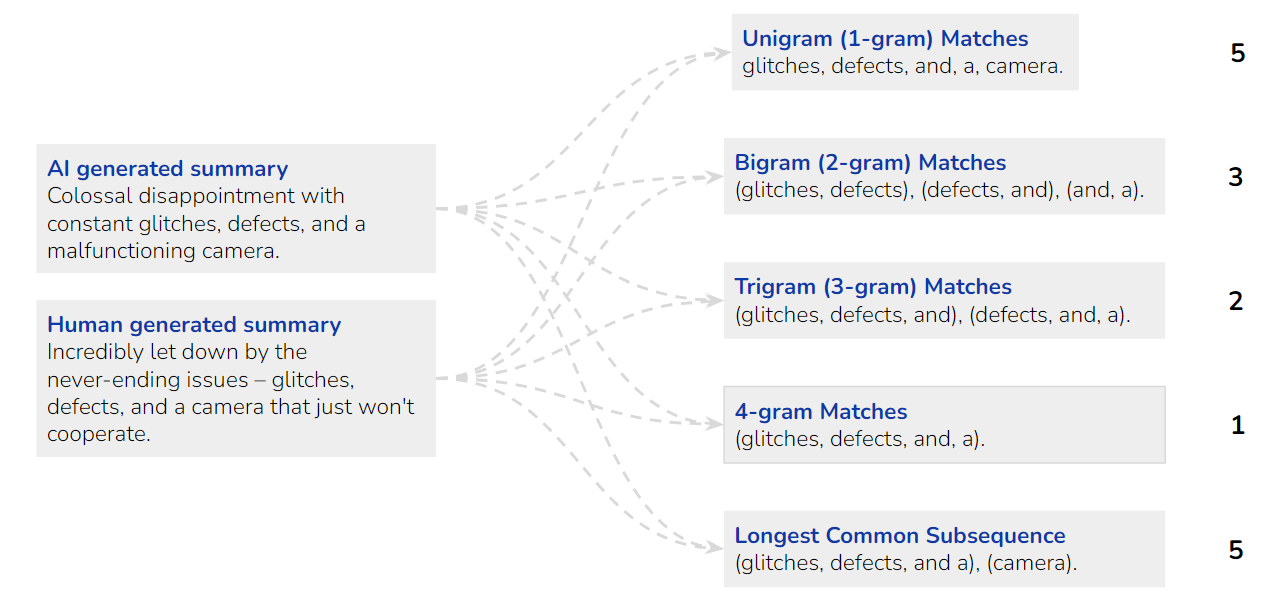

The $\text{ROUGE}_{N}$ score is computed using the ratio of the number of n-gram matches to the total number of n-grams in the human generated summary. However, we still have to make a choice whether unigram, bigram, or any other n-gram should be used.

To solve this conundrum, a common variant of ROUGE that is used to generate a comparison metric is $\text{ROUGE}_{\text{L}}$, where we first compute the recall and precision of the longest common subsequence and then compute the harmonic mean of these values (punctuation and case of the word are disregarded).

In [ ]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

As seen in the figure above, the length of the largest common subsequence between the two summaries is 5. The number of unigrams in the AI-generated summary is 10 and the number of unigrams in the human generated summary is 17. From these measures, we can compute $\text{ROUGE}_{\text{L}}$ like so:

In [ ]:
r_lcs, p_lcs = 5/17, 5/10
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs) # rouge-L

0.37037037037037035

One important limitation of ROUGE is that it accounts for exact matches. This means that a summary that uses semantically close words would receive a poor score despite capturing the intent of the human summary. For extractive summarization ROUGE would be a good metric, but for abstractive summarization it would be too harsh.

Hence we need a new metric that focuses on the meaning of the words in the summary rather than an exact match.

In [ ]:
# Extract the first 10 dialogues and their human baseline summaries from the dataset
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

# Initialize lists to store summaries generated by the original model and the PEFT model
original_model_summaries = []
peft_model_summaries = []

# Loop through the dialogues and generate summaries for each
for idx, dialogue in enumerate(dialogues):
    # Create a prompt for summarizing the conversation
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    # Tokenize the prompt and convert it to PyTorch tensors
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # Get the human baseline summary
    human_baseline_text_output = human_baseline_summaries[idx]

    # Generate a summary using the original model with specific generation settings
    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    # Generate a summary using the PEFT model with specific generation settings
    peft_model_outputs = peft_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    # Append the generated summaries to their respective lists
    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

# Create a list of tuples where each tuple contains the human baseline summary, original model summary, and PEFT model summary
zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

# Create a Pandas DataFrame to organize and display the summaries
df = pd.DataFrame(zipped_summaries, columns=['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df


,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,This is an intra-office memo.,This memo is intended to be an intra-office memo.
1,In order to prevent employees from wasting tim...,This memo is a memo to employees regarding the...,This memo is intended to be an intra-office memo.
2,Ms. Dawson takes a dictation for #Person1# abo...,Public Employees must be notified of the new o...,This memo is intended to be an intra-office memo.
3,#Person2# arrives late because of traffic jam....,This is the first time in a year that the comp...,"If you're a car driver, you may want to consid..."
4,#Person2# decides to follow #Person1#'s sugges...,Taking the subway would be a lot less stressfu...,"If you're a car driver, you may want to consid..."
5,#Person2# complains to #Person1# about the tra...,Taking public transport to work is a good idea...,"If you're a car driver, you may want to consid..."
6,#Person1# tells Kate that Masha and Hero get d...,The new couple are having a separation for 2 m...,The couple have a separation for 2 months and ...
7,#Person1# tells Kate that Masha and Hero are g...,The couple is having a separation for 2 months...,The couple have a separation for 2 months and ...
8,#Person1# and Kate talk about the divorce betw...,The new couple Masha and Hero are having a sep...,The couple have a separation for 2 months and ...
9,#Person1# and Brian are at the birthday party ...,The party was a great success.,"Happy birthday, Brian!"


In [ ]:
# Load the ROUGE (Recall-Oriented Understudy for Gisting Evaluation) evaluation module
rouge = evaluate.load('rouge')

# Calculate ROUGE scores for the summaries generated by the original model
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,  # Aggregator is used to compute aggregate ROUGE scores
    use_stemmer=True,     # Stemmer is used for word stemming during evaluation
)

# Calculate ROUGE scores for the summaries generated by the PEFT model
peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,  # Aggregator is used to compute aggregate ROUGE scores
    use_stemmer=True,     # Stemmer is used for word stemming during evaluation
)

# Print the ROUGE scores for the original model
print('ORIGINAL MODEL:')
print(original_model_results)

# Print the ROUGE scores for the PEFT model
print('PEFT MODEL:')
print(peft_model_results)


ORIGINAL MODEL:
{'rouge1': 0.21230580435329444, 'rouge2': 0.04349881796690307, 'rougeL': 0.1540531164618958, 'rougeLsum': 0.15692378525831643}
PEFT MODEL:
{'rouge1': 0.17313192713650383, 'rouge2': 0.03613554903877485, 'rougeL': 0.14375106266973472, 'rougeLsum': 0.14529977151683066}


Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the `data/dialogue-summary-training-results.csv` file. Load the values for the PEFT model now and check its performance compared to other models.

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over HUMAN BASELINE
rouge1: -3.92%
rouge2: -0.74%
rougeL: -1.03%
rougeLsum: -1.16%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).



---

